<h1 style="text-align: center;">
  Challenge de classification MS COCO
</h1>


Guewen HAUTBOIS</br>
Marie FRIOT</br>
5TC-IAV

Ce jupyter notebook est notre rendu pour le challenge de classification MS COCO, l'ensemble des poids obtenus après entrainement et les prédictions du jeu de test qui y sont associées sont disponibles sur ce [drive](https://drive.google.com/drive/folders/1Ph854utgqsWwWtt_rlG6POq48OrrjYMS?usp=sharing)


## 1. Présentation des données :

Les images issues de la base de données sont des images naturelles encodées sur trois canaux (R,G,B) avec des intensités variant entre 0 et 255. 
Nos images ont une taille comprise entre 36 x 224 et 224 x 224.
Pour que nos modèles, entraîné également sur des images naturelles (base de donnée ImageNet-1k), puissent performer sur les images de MS-COCO, il est nécessaire que les images de notre base de données soient transformées pour “ressembler” aux images que notre modèle a pu rencontrer lors de son entraînement.

### 1.1. Exemple : RegNetY-16GF

Dans le cas de RegNetY-16GF, le modèle a été pré-entraîné sur des images de taille 384x384. Il est donc nécessaire de redimensionner les images à cette dimension avant d’inférer les images de MS-COCO. Cela permet de conserver l’information de distance et de taille relative apprise par le modèle lors de son entraînement sur ImageNet. Ce redimensionnement se fait exactement comme lors du premier entraînement du modèle avec les mêmes transformations. De plus,  les images de ImageNet ont été ré-échelonnées avec une certaine distribution d’intensité sur chaque canaux. Nous devons donc faire ce même ré-échelonnage sur nos images car le modèle a appris certaines caractéristiques liées à cette distribution des niveaux d’intensité. 
Toutes les transformations sont composées dans la fonction RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1.transforms et sont résumées ici : 
- Redimensionnement du côté le plus court à une taille de 384 pixels avec une interpolation bicubique
- recadrage central à la taille 384x384
- ré-echelonnage des valeurs entre 0 et 1 
- normalisation avec une moyenne=[0.485, 0.456, 0.406] et un ecart_type=[0.229, 0.224, 0.225]

*Remarque :  Nos images sont plus petites que celles utilisées pour entraîner le modèle. Elles sont donc sur-échantillonnées. Ceci peut entraîner de la perte d’information sur les détails fins et compliquer la tâche de classification du modèle.*

Malgré le fait que ImageNet-1k contienne 1000 classes, certaines classes de MS-COCO n’y sont pas présentent comme les classes brosse à dent, évier ou sandwich. Notre modèle devrait donc avoir plus de difficultés pour ces classes dont il n’a jamais appris les caractéristiques que pour d’autres classes comme zèbre, koala et chat qu’il a pu déjà apprendre à reconnaître sur le jeu de données ImageNet-1k.

## 2. Choix/Présentation des modèles :

### 2.1. RegNetY-16GF

Nous avons choisi un modèle parmi les modèles pré-entraînés sur ImageNet-1K disponibles dans la librairie PyTorch. Notre premier choix s’est porté sur RegNetY-16GF, car c’est l’un des modèles avec la meilleure *accuracy* sur ImageNet-1K (86.012) et possédant un nombre de paramètres assez raisonnable (83.6 millions environ). Il a été entrainé avec une méthode d'entrainement des poids auto-supervisé de type SWAG (Supervised Weakly though hastAGs), proposé par [Singh et al. (2022)](https://arxiv.org/abs/2201.08371). Ce modèle est un réseau de neurones convolutif ayant une architecture similaire à celle de ResNet : il est constitué de blocs de convolutions reliés entre eux par des connexions résiduelles.

En revanche, son design provient d’un nouvel espace de conception proposé par [Radosavovic et al. (2020)](https://arxiv.org/abs/2003.13678). Les auteurs ont montré que de meilleures performances pouvaient être obtenues lorsque la largeur des blocs est définie par une fonction linéaire quantifiée.
Cette fonction prend en paramètre la largeur initiale du modèle, la pente de croissance et la profondeur désirée de ce modèle. L’exploration de ces paramètres et donc de cet espace de conception réduit permet d’identifier les modèles offrant la meilleure précision en fonction d’une complexité fixée. Pour RegNetY-16GF cette complexité est de 16 GFLOPS.

De plus, ce modèle utilise des convolutions groupées où les canaux d’entrée sont divisés en groupes. Pour chacuns des groupes les noyaux de convolution sont indépendants. Cela permet de réduire le coût de calcul qui est divisé par le nombre de groupes pour chaque blocs de convolution. De plus, comme les groupes sont indépendants les uns des autres, cela permet de paralléliser l’inférence, tout en apprenant des filtres différents, ce qui permet au modèle d’apprendre une meilleure représentation des données.

Pour finir, ce modèle possède un modèle SE (Squeeze and Excitation). Chaque bloc de RegNetY contient un module qui agit comme un contrôleur d’attention par canal. Dans un premier temps, les cartes de caractéristiques de chaque canal sont moyennées (Global Average Pooling). On obtient donc pour chaque canal une valeur moyenne représentant la carte de caractéristique du canal correspondant. Ces valeurs passent ensuite dans un MLP à deux couches (implémenté avec des convolutions 1x1) suivi d’une activation non linéaire (ReLU). Cela permet au modèle d’apprendre l’importance relative des canaux. La sortie de ce MLP, suivie d’une fonction d’activation (sigmoid) permet d’obtenir des poids qui vont permettre de pondérer les cartes d’activation en fonction de leur importance.

### 2.2 Vision Transformer

Afin d’avoir une diversité de modèle, nous avons choisi de prendre un Vision Transformer. À l’instar de notre choix de modèle et de poids sur RegNet, nous avons choisi VIT_b_16, car c’est un modèle qui a une très bonne *accuracy* sur le jeu de données ImageNet-1K (85.304), qui a lui aussi été combiné à une méthode d’auto-supervision SWAG tout en possédant un nombre de paramètres raisonnable (86.9 millions environ). Ce modèle proposé par [Dosovitskiy et al. (2021)](https://arxiv.org/abs/2010.11929), fonctionne en découpant les images en plusieurs imagettes de petite taille. Celles-ci serviront à alimenter un mécanisme d’auto-attention au sein du réseau, permettant d'extraire les caractéristiques des images qui seront ensuite utilisées pour la classification.

## 3. Méthode d'entrainement

Pour obtenir de bonnes performances sans ré-entraîner complètement un modèle nous avons fait de l’apprentissage par transfert. Pour cela, nous avons choisi de geler tous les paramètres initiaux du modèle hormis la dernière couche pleinement connectée que nous avons modifiée pour que le modèle ait 80 têtes de classification. Nous avons fait ce choix car cela permet de limiter le temps et le coût d'entraînement : la mise à jour des poids entre chaque lot ne se fait que sur 242 000 paramètres au lieu de 84 millions. De plus, cela évite les phénomènes d’oublis qui peuvent survenir, lors d’un ré-entraînement complet, lorsque le taux d’apprentissage est trop important.

Afin d'avoir un entraînement à la fois rapide, tout en limitant l'instabilité lors de la rétro-propagation nous avons pris une taille de lot de 64 images. Cette valeur a aussi été déterminée afin de ne pas surpasser les capacités de mémoire de nos GPU.

## 4. Choix de la fonction de perte

Nous avons affaire à un problème de classe multi-étiquette : plusieurs classes peuvent être présentes dans une même image. Notre base de données comportant 80 classes, notre modèle possède 80 têtes de classification qui sortent des valeurs probabilistes issues de sigmoïdes. Le modèle est ensuite optimisé avec une entropie binaire croisée (BCELoss).

Notre base de données étant très déséquilibrée (55% des étiquettes sont des personnes, alors que les brosses à dent représentent 0.8% des étiquettes), nous avons décidé d’utiliser une fonction de coût prenant en compte cette disparité. Nous avons donc ajouté des poids dans notre entropie binaire croisée pour donner plus d’importance aux classes rares. Les poids correspondent à l’inverse de la fréquence des classes dans notre groupe d’images d'entraînement.

Nous avons pu constater l’utilité de ce paramètre lors du réentraînement de notre modèle RegNet-16GF sur 5 epochs en utilisant une descente de gradient stochastique. En effet, le F1-score sur le jeu de validation a pu passer de 0.4, sans pondération de la fonction de coût à 0.49. Cela est dû à l'amélioration des scores de classification sur les classes plus rares.

## 5. Choix de l'optimiseur

Nous avons décidé d’utiliser ADAM afin que le modèle apprenne et converge plus vite qu’avec une descente de gradient stochastique. En effet, au bout de 5 epochs, avec une descente de gradient stochastique et un taux d’apprentissage assez grand (0.01), le F1-score sur les données de validation est de 0.50 contre 0.55 avec Adam paramétré avec un taux d’apprentissage initial  de 0.0001.

Le choix de ce taux d’apprentissage pour Adam est important. Nous avons constaté qu’avec un taux d’apprentissage trop grand (0.01), l’apprentissage de notre modèle devient très instable. En effet, si le momentum est élevé en début d'entraînement (car les gradients sont élevés à ce moment-là), et si le taux d’apprentissage est trop grand, les poids risques d’être mis à jour trop fortement ce qui cause cette instabilité.

## 6. Régularisation de la variance

Nous avons pu observer que nos modèles avaient une très grande variance entre les scores sur le jeu d'entraînement et les scores sur le jeu de test et de validation. 

Pour régler cela, nous avons essayé deux méthodes. La première était d’utiliser AdamW (Adam avec une pénalisation des poids : weight-decay). Cette méthode permet de réduire la valeur des poids trop gros. Si certains poids deviennent trop importants dans la prise de décision lors de l'entraînement, ils peuvent être sur-adaptés au jeu d’entraînement : le modèle apprend par cœur. A l’inverse, si on les pénalise, le modèle reste simple et équilibré : tous les poids participent à la décision, ce qui lui permet de mieux généraliser. 
Avec AdamW et la valeur par défaut de pénalisation des poids (0.01), nous n’avons cependant pas perçu de diminution de la variance. 


Nous avons également essayé d’implémenter un mécanisme de *dropout* juste avant la couche pleinement connectée. Ce mécanisme permet de mettre à zero aléatoirement certains poids, incitant le modèle à apprendre sur tous ses poids en ne basant pas ses choix que sur certains. Cela permet d’améliorer la capacité à généraliser du modèle et de le rendre plus robuste à de nouveaux cas.
Avec ce mécanisme paramétré avec une probabilité de 0.25, nous n'avons pas constaté d’améliorations.

## 7. Analyse des résultats

### 7.1. RegNetY-16GF
Cette partie analyse des résultats se concentre sur les résultats obtenus avec notre meilleur modèle : RegNetY-16GF entraîné avec Adam.

<center>

| Mesure | Valeur | 
|--- |:-: | 
| accuracy | 0.6399 |
| f1-score | 0.6658 |
| precision | 0.8865 |
| recall | 0.5330 |
</center>
<center>
Tableau 1 : Résultats des métriques de classification
</center>
<br>
On peut constater que notre modèle a un score de précision assez élevé sur le jeu de test (0.89) alors que son score de rappel est plus mauvais (0.53). Cela veut dire qu’il donne un nombre de faux-positifs faibles mais un nombre de faux négatifs élevés. Notre modèle est donc assez frileux : lorsqu’il prédit quelque chose, c’est très souvent vrai. En revanche, il ne prédit pas un très grand nombre de classes : il rate beaucoup de vrais positifs. 
 
Cette différence de score peut être aussi généralement constatée sur toutes les classes de la base de données MS-COCO mais est beaucoup plus importante sur les classes faiblement représentées. Par exemple, pour les ciseaux qui représentent 0.9% des étiquettes du jeu d’entraînement, la précision sur ce jeu de données est de 0,96 alors que le rappel est de 0,52. A l’inverse, pour la classe personne représentant 55% des étiquettes du jeu d’entraînement, la précision est de 0.97 et le rappel est plutôt similaire : 0.91. 

En revanche, cette différence entre le rappel et la précision ne peut pas s’expliquer seulement par le déséquilibre de classe. En effet, les avions et les bus qui représentent respectivement 2.5% et 3.4% des étiquettes ont des scores de précision assez similaires (0.99 et 0.97)  alors que les scores de rappel sont assez différents (0.98 et 0.69). L'hypothèse de la différence de fréquence d’apparition de ces deux classes sur le jeu d'entraînement n’explique pas ce phénomène car les deux classes sont présentes à peu près sur le même nombre d’images. En revanche on peut penser que cela est dû à une difficulté différente de la tâche de classification pour les deux objets. En effet, il semble plus évident de trouver un avion dans un ciel bleu, qu’un bus au milieu d’une ville, entouré d’objets similaires comme des camions. En revanche, la classe avion n’est pas présente dans ImageNet-1k alors que la classe bus l’est. Le mauvais rappel sur les bus comparé aux avions ne peut donc pas se justifier par le fait que le modèle ait déjà appris la classe avion lors de son entraînement sur ImageNet-1k. L’hypothèse de différence de difficulté de classification semble donc être la plus pertinente pour ce phénomène. 

Pour conclure sur la différence de score entre le rappel et la précision, si l’on diminue le seuil de classification, le score de rappel augmente. En effet, on sort des classifications avec une probabilité plus faible, ce qui permet de rappeler un plus grand nombre de cas. Par exemple avec un seuil de 0.4 le score total de précision est de 0.83 (contre 0.89 avec un seuil de 0.5) alors que le score de rappel est de 0.56 (contre 0.53 avec un seuil de 0.5).

### 7.2. ViT

Nous avons testé un modèle de type Vision Transfomer, entraîné de la même façon et avec un nombre de paramètre équivalent à celui de RegNetY-16GF pour déterminer si une architecture de type transformer à dimension équivalente, peut dépasser un réseau convolutif.

Après le même nombre d'epochs d'entrainement que sur RegNetY-16GF, en utilisant la même fonction de coût (entropie binaire croisée), et le même optimiser (ADAM avec un taux d'aprentissage de 0.0001), nous avons obtenue un score F-1 sur le jeu d'entrainement plus faible avec le ViT (0.64) qu'avec RegNetY-16GF (0.72). En revanche le ViT semble avoir de meilleures capacitées de généralisation car son  score F-1 est de 0.6 sur le jeu de test (contre 0.66 pour RegNetY-16GF).

On peut imaginer que cette différence de performance est due au fait que les transformeurs de vision ont besoin de beaucoup plus de données que les CNN pour acquérir des scores équivalents. En effet les CNN intègrent un biais inductif important grâce à la convolution qui impose une invariance par translation et exploite la localité des motifs visuels. A l'inverse, le méchanisme d'auto attention permet au modèle d'apprendre des relations entre des parties de l'image très éloignée. En revanche, comme il n'a pas de biais inductif il doit apprendre les relations locales avec des données.


## Perspectives

Pour déterminer le meilleur schéma de ré-entraînement du modèle et les meilleurs hyper-paramètres nous pourrions effectuer une recherche aléatoire. Cela pourrait concerner le taux d’apprentissage, les valeurs des coefficients de Adam et la valeur de pénalisation des poids.
Pour limiter le sur-apprentissage, nous pourrions également tester l’augmentation de données. Cette augmentation de données pourrait se réaliser en fonction de la fréquence des classes pour rééquilibrer la présence des classes.

---

## Import des bibliothèques

In [1]:
import os
from glob import glob
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchvision.models import regnet_y_16gf, RegNet_Y_16GF_Weights
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchinfo import summary

from tqdm import tqdm

import json

## Définition des datasets

In [2]:
class COCOTrainImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, annotations_dir, max_images=None, transform=None):
        self.img_labels = sorted(glob("*.cls", root_dir=annotations_dir))
        if max_images:
            self.img_labels = self.img_labels[:max_images]
        self.img_dir = img_dir
        self.annotations_dir = annotations_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, Path(self.img_labels[idx]).stem + ".jpg")
        labels_path = os.path.join(self.annotations_dir, self.img_labels[idx])

        image = Image.open(img_path).convert("RGB")
        with open(labels_path) as f: 
            labels = [int(label) for label in f.readlines()]
        if self.transform:
            image = self.transform(image)
        labels = torch.zeros(80).scatter_(0, torch.tensor(labels), value=1)
        return image, labels


class COCOTestImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_list = sorted(glob("*.jpg", root_dir=img_dir))    
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_list[idx])
        image = Image.open(img_path).convert("RGB")        
        if self.transform:
            image = self.transform(image)
        return image, Path(img_path).stem # Nom du fichier sans extension

## Boucle d'entraînement et de validation 

In [3]:
def train_loop(train_loader, net, criterion, optimizer, device,
               mbatch_loss_group=-1):
    net.train()
    running_loss = 0.0
    mbatch_losses = []
    for i, data in enumerate(tqdm(train_loader, desc="Training", unit="batch")):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # following condition False by default, unless mbatch_loss_group > 0
        if i % mbatch_loss_group == mbatch_loss_group - 1:
            mbatch_losses.append(running_loss / mbatch_loss_group)
            running_loss = 0.0
    if mbatch_loss_group > 0:
        return mbatch_losses


def validation_loop(val_loader, net, criterion, num_classes, device,
                    multi_task=False, th_multi_task=0.5, one_hot=False, class_metrics=False):
    net.eval()
    loss = 0
    correct = 0
    size = len(val_loader.dataset)
    class_total = {label:0 for label in range(num_classes)}
    class_tp = {label:0 for label in range(num_classes)}
    class_fp = {label:0 for label in range(num_classes)}
    with torch.no_grad():
        for data in tqdm(val_loader, desc="Validation", unit="batch"):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item() * images.size(0)
            if not multi_task:    
                predictions = torch.zeros_like(outputs)
                predictions[torch.arange(outputs.shape[0]), torch.argmax(outputs, dim=1)] = 1.0
            else:
                predictions = torch.where(outputs > th_multi_task, 1.0, 0.0)
            
            if not one_hot:
                labels_mat = torch.zeros_like(outputs)
                labels_mat[torch.arange(outputs.shape[0]), labels] = 1.0
                labels = labels_mat
                
            tps = predictions * labels
            fps = predictions - tps
            
            tps = tps.sum(dim=0)
            fps = fps.sum(dim=0)
            lbls = labels.sum(dim=0)  
                
            for c in range(num_classes):
                class_tp[c] += tps[c]
                class_fp[c] += fps[c]
                class_total[c] += lbls[c]
                    
            correct += tps.sum()

    class_prec = []
    class_recall = []
    freqs = []
    for c in range(num_classes):
        class_prec.append(0 if class_tp[c] == 0 else
                          class_tp[c] / (class_tp[c] + class_fp[c]))
        class_recall.append(0 if class_tp[c] == 0 else
                            class_tp[c] / class_total[c])
        freqs.append(class_total[c])

    freqs = torch.tensor(freqs)
    class_weights = 1. / freqs
    class_weights /= class_weights.sum()
    class_prec = torch.tensor(class_prec)
    class_recall = torch.tensor(class_recall)
    prec = (class_prec * class_weights).sum()
    recall = (class_recall * class_weights).sum()
    f1 = 2. / (1/prec + 1/recall)
    val_loss = loss / size
    accuracy = correct / freqs.sum()
    results = {"loss": val_loss, "accuracy": accuracy, "f1": f1,\
               "precision": prec, "recall": recall}

    if class_metrics:
        class_results = []
        for p, r in zip(class_prec, class_recall):
            f1 = (0 if p == r == 0 else 2. / (1/p + 1/r))
            class_results.append({"f1": f1, "precision": p, "recall": r})
        results = results, class_results

    return results

## Suivi avec Tensorboard

In [4]:
def update_graphs(summary_writer, epoch, train_results, test_results,
                  train_class_results=None, test_class_results=None, 
                  class_names = None, mbatch_group=-1, mbatch_count=0, mbatch_losses=None):
    if mbatch_group > 0:
        for i in range(len(mbatch_losses)):
            summary_writer.add_scalar("Losses/Train mini-batches",
                                  mbatch_losses[i],
                                  epoch * mbatch_count + (i+1)*mbatch_group)

    summary_writer.add_scalars("Losses/Train Loss vs Test Loss",
                               {"Train Loss" : train_results["loss"],
                                "Test Loss" : test_results["loss"]},
                               (epoch + 1) if not mbatch_group > 0
                                     else (epoch + 1) * mbatch_count)

    summary_writer.add_scalars("Metrics/Train Accuracy vs Test Accuracy",
                               {"Train Accuracy" : train_results["accuracy"],
                                "Test Accuracy" : test_results["accuracy"]},
                               (epoch + 1) if not mbatch_group > 0
                                     else (epoch + 1) * mbatch_count)

    summary_writer.add_scalars("Metrics/Train F1 vs Test F1",
                               {"Train F1" : train_results["f1"],
                                "Test F1" : test_results["f1"]},
                               (epoch + 1) if not mbatch_group > 0
                                     else (epoch + 1) * mbatch_count)

    summary_writer.add_scalars("Metrics/Train Precision vs Test Precision",
                               {"Train Precision" : train_results["precision"],
                                "Test Precision" : test_results["precision"]},
                               (epoch + 1) if not mbatch_group > 0
                                     else (epoch + 1) * mbatch_count)

    summary_writer.add_scalars("Metrics/Train Recall vs Test Recall",
                               {"Train Recall" : train_results["recall"],
                                "Test Recall" : test_results["recall"]},
                               (epoch + 1) if not mbatch_group > 0
                                     else (epoch + 1) * mbatch_count)

    if train_class_results and test_class_results:
        for i in range(len(train_class_results)):
            summary_writer.add_scalars(f"Class Metrics/{class_names[i]}/Train F1 vs Test F1",
                                       {"Train F1" : train_class_results[i]["f1"],
                                        "Test F1" : test_class_results[i]["f1"]},
                                       (epoch + 1) if not mbatch_group > 0
                                             else (epoch + 1) * mbatch_count)

            summary_writer.add_scalars(f"Class Metrics/{class_names[i]}/Train Precision vs Test Precision",
                                       {"Train Precision" : train_class_results[i]["precision"],
                                        "Test Precision" : test_class_results[i]["precision"]},
                                       (epoch + 1) if not mbatch_group > 0
                                             else (epoch + 1) * mbatch_count)

            summary_writer.add_scalars(f"Class Metrics/{class_names[i]}/Train Recall vs Test Recall",
                                       {"Train Recall" : train_class_results[i]["recall"],
                                        "Test Recall" : test_class_results[i]["recall"]},
                                       (epoch + 1) if not mbatch_group > 0
                                             else (epoch + 1) * mbatch_count)
    summary_writer.flush()

## Définition des variables et hyperparamètres

In [ ]:
train_dir = "./ms-coco/images/train-resized"
annotation_dir = "./ms-coco/labels/train"
test_dir = "./ms-coco/images/test-resized"

checkpoint_path = "best_model_checkpoint.pt"
num_epoch = 10
minibatch_size = 64
learning_rate = 0.0001

classes = ["person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light", 
           "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
           "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",       
           "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
           "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
           "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", 
           "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", 
           "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", 
           "hair drier", "toothbrush"]
num_classes = len(classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")

Using cuda device.


## Test des dataloaders

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6384196..1.8996525].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.66346514..1.902985].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6294924..1.9261692].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5822209..1.8149837].


Taille du jeu d'entraînement : 18
Taille du jeu de validation : 2
Taille du jeu de test : 4952


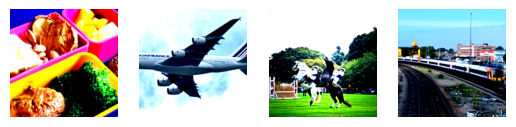

In [8]:
def imshow(ax, img, title):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0))) 
    ax.set_title(title)
    ax.axis("off")

transform = transforms.Compose([
    transforms.ToTensor(),
    RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1.transforms()
])

trainDataset = COCOTrainImageDataset(train_dir,annotation_dir, transform=transform, max_images=20)
test_set = COCOTestImageDataset(test_dir,transform=transform)

# Séparation du jeu d'entraînement et de validation
generator = torch.Generator().manual_seed(42)
val_set, train_set = torch.utils.data.random_split(trainDataset, [0.1,0.9], generator=generator)

print("Taille du jeu d'entraînement :", len(train_set))
print("Taille du jeu de validation :", len(val_set))
print("Taille du jeu de test :", len(test_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=4,shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4,shuffle=False, num_workers=0)

it = iter(train_loader) 
images, labels = next(it) 

fig, ax = plt.subplots(1, 4)

for i, (img, label) in enumerate(zip(images, labels)):
    imshow(ax[i], img, '')

## Calcul du nombre d'images par classe

In [ ]:
trainDataset = COCOTrainImageDataset(train_dir,annotation_dir, transform=None)
counts = torch.zeros(80)
for i in range(len(trainDataset)):
    _, label = trainDataset[i]  
    counts += label

print(counts)
N = len(trainDataset)

# Fréquence d'apparition de chaque classe
freq = counts/N
print(freq)

# Poids pour chaque classe
weight = N/counts
torch.save(weight, "weight.pt")

tensor([35494.,  1821.,  6811.,  1958.,  1647.,  2178.,  1992.,  3416.,  1669.,
         2305.,   967.,   962.,   396.,  3076.,  1780.,  2305.,  2423.,  1602.,
          809.,  1078.,  1187.,   516.,  1083.,  1418.,  3141.,  2220.,  3826.,
         2097.,  1326.,  1277.,  1679.,   898.,  2340.,  1261.,  1375.,  1421.,
         1880.,  1962.,  1880.,  4719.,  1381.,  5057.,  2002.,  2437.,  1967.,
         3960.,  1237.,   914.,  1313.,   940.,  1027.,   919.,   667.,  1782.,
          856.,  1652.,  7043.,  2440.,  2480.,  2033.,  6546.,  1885.,  2481.,
         1990.,  1030.,  1738.,  1136.,  2692.,   832.,  1575.,   117.,  2602.,
         1305.,  2978.,  2588.,  1984.,   555.,  1193.,   102.,   561.])
tensor([0.5461, 0.0280, 0.1048, 0.0301, 0.0253, 0.0335, 0.0306, 0.0526, 0.0257,
        0.0355, 0.0149, 0.0148, 0.0061, 0.0473, 0.0274, 0.0355, 0.0373, 0.0246,
        0.0124, 0.0166, 0.0183, 0.0079, 0.0167, 0.0218, 0.0483, 0.0342, 0.0589,
        0.0323, 0.0204, 0.0196, 0.0258, 0.0138,

## Initialisation du modèle

*Remarque : Le fichier "weight.pt" étant obligatoire pour le bon fonctionnement de la prochaine cellule, il est disponible en téléchargement sur ce [drive](https://drive.google.com/file/d/1xip10UCC6DIcZHe-OCEXPMPedrKHurxY/view?usp=sharing), ou alors, il suffit d'éxécuter la cellule précédente*

In [10]:
model = regnet_y_16gf(weights=RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1)
for param in model.parameters() :
    param.requires_grad = False
model.fc = torch.nn.Sequential(
    torch.nn.Linear(3024, 80),
    torch.nn.Sigmoid() 
)

model = model.to(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1.transforms()
])

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

weight = torch.load("weight.pt", weights_only=True).to(device)
criterion = torch.nn.BCELoss(weight=weight)

## Affichage du modèle

In [11]:
summary(model,input_size=(1, 3, 384, 384))

Layer (type:depth-idx)                                  Output Shape              Param #
RegNet                                                  [1, 80]                   --
├─SimpleStemIN: 1-1                                     [1, 32, 192, 192]         --
│    └─Conv2d: 2-1                                      [1, 32, 192, 192]         (864)
│    └─BatchNorm2d: 2-2                                 [1, 32, 192, 192]         (64)
│    └─ReLU: 2-3                                        [1, 32, 192, 192]         --
├─Sequential: 1-2                                       [1, 3024, 12, 12]         --
│    └─AnyStage: 2-4                                    [1, 224, 96, 96]          --
│    │    └─ResBottleneckBlock: 3-1                     [1, 224, 96, 96]          (295,912)
│    │    └─ResBottleneckBlock: 3-2                     [1, 224, 96, 96]          (352,856)
│    └─AnyStage: 2-5                                    [1, 448, 48, 48]          --
│    │    └─ResBottleneckBlock: 3-3      

## Entraînement

In [ ]:
trainDataset = COCOTrainImageDataset(train_dir,annotation_dir,transform=transform) #max_images=30

# Séparation du jeu d'entraînement et de validation
generator = torch.Generator().manual_seed(42)
val_set, train_set = torch.utils.data.random_split(trainDataset, [0.1,0.9], generator=generator)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=minibatch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=minibatch_size,shuffle=False, num_workers=0)

if os.path.exists(checkpoint_path): #si on a un checkpoint
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # repartir de l'epoch suivant
    print(f"Checkpoint trouvé. Reprise depuis l'epoch {start_epoch}")
else:
    start_epoch = 0
    print("Pas de checkpoint. Démarrage depuis l'epoch 0")

# Initialisation de la mesure des performances
best_f1 = 0
summary_writer = SummaryWriter(log_dir="runs/BCEWeighted")

# Boucle d'entraînement
for epoch in range(start_epoch, num_epoch) :
    print(f"Epoch {epoch+1}/{num_epoch}")
#   Entraînement
    mbatch_losses = train_loop(train_loader, model, criterion, optimizer, device,mbatch_loss_group=-1)
#   validation sur le jeu d'entraînement
    train_results = validation_loop(train_loader, model, criterion, num_classes, device,multi_task=True, th_multi_task=0.5, one_hot=True, class_metrics=True)
#   validation sur le jeu de validation
    val_results = validation_loop(val_loader, model, criterion, num_classes, device,multi_task=True, th_multi_task=0.5, one_hot=True, class_metrics=True)
#   sauvegarde du modèle si amélioration du F1-score
    f1 = val_results[0]["f1"]
    if f1 > best_f1 : 
        checkpoint = {
            'epoch': epoch,  
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),  
            }
        torch.save(checkpoint, checkpoint_path)
        best_f1 = f1

#   mise à jour des graphiques dans TensorBoard
    update_graphs(summary_writer, epoch, train_results[0], val_results[0],
                train_class_results=train_results[1], test_class_results=val_results[1], 
                class_names = classes, mbatch_group=-1, mbatch_count=0, mbatch_losses=None)

summary_writer.close()

## Prédiction des données de test

In [ ]:
test_set = COCOTestImageDataset(test_dir,transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=minibatch_size,shuffle=False, num_workers=0)

model = regnet_y_16gf(weights=RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1)
for param in model.parameters() :
    param.requires_grad = False
model.fc = torch.nn.Sequential(
    torch.nn.Linear(3024, 80),
    torch.nn.Sigmoid() 
)
model.load_state_dict(torch.load(checkpoint_path)["model_state_dict"])
model = model.to(device)

print("Meilleure epoch :", torch.load(checkpoint_path)["epoch"]+1)

output_json = "predictions.json"

model.eval()
predictions_dict = {}

# Boucle de prédiction
for i, data in enumerate(test_loader) :
    inputs, filename = data[0].to(device), data[1]
    outputs = model(inputs)
    # Pour du multi-label, on choisit un seuil de 0.4
    predictions = torch.where(outputs >0.4, 1.0, 0.0)
  
    for j in range(predictions.shape[0]) : # Pour toutes les images du batch
        classes = torch.nonzero(predictions[j]).squeeze().tolist()
        if isinstance(classes, int):
            classes = [classes]
        file = filename[j]
        predictions_dict[file] = classes

with open(output_json, "w") as f:
    json.dump(predictions_dict, f, indent=4)

C:\Users\kergu\AppData\Local\Temp\ipykernel_17584\364694965.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path)["model_sta

Meilleure epoch : 10
